In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
path = "/content/drive/My Drive/M2/DeepLearning"

import sys
sys.path.append(path)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
print(train_images.shape)
print(test_images.shape)


import mnist_reader
X_train, y_train = mnist_reader.load_mnist(path+'/Datasets', kind='train')
X_test, y_test = mnist_reader.load_mnist(path+'/Datasets', kind='t10k')
print(X_train.shape)
print(X_test.shape)

X_train, X_test, train_images, test_images = X_train / 255.0, X_test / 255.0, train_images / 255.0, test_images / 255.0

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 784)
(10000, 784)


### **1. Deep Autoencoder**

In [0]:
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score



#################################################
# Hyper-parameters
#################################################
epoch = 200
batch_size = 256

encoding_dim = 7*7
hidden_dim = 512

activation='elu'
optimizer='adam'
loss='mean_squared_error'
loss='binary_crossentropy'
#################################################

out_activation = 'sigmoid' if loss=='binary_crossentropy' else 'linear'
if activation=='leaky_relu':
  activation=None

#################################################
# Auto-encoder
#################################################
input_img = Input(shape=(784,))


####### Encoder #######
#   Layer
encoded = Dense(hidden_dim, activation=activation)(input_img)
if activation is None: encoded = layers.LeakyReLU()(encoded)

#   Layer
encoded = Dense(hidden_dim//4, activation=activation)(encoded)
if activation is None: encoded = layers.LeakyReLU()(encoded)

#   Layer
encoded = Dense(encoding_dim, activation=out_activation)(encoded)


####### Decoder #######
#   Layer
decoded = Dense(hidden_dim//4, activation=activation)(encoded)
if activation is None: decoded = layers.LeakyReLU()(decoded)

#   Layer
decoded = Dense(hidden_dim, activation=activation)(decoded)
if activation is None: decoded = layers.LeakyReLU()(decoded)

#   Layer
decoded = Dense(784, activation=out_activation)(decoded)


####### Make model #######
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()


####### Train #######
autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test))


####### Encode images #######
encoder = Model(input_img, encoded)
encoded_images = encoder.predict(X_train)
#################################################



#################################################
# KMeans
#################################################
print("run KMeans")
kmeans = KMeans(n_clusters=10, n_init=20)
kmeans.fit(encoded_images)

print(nmi(kmeans.labels_, y_train))
print(ari(kmeans.labels_, y_train))
#################################################

### **2. Deep Convolutional Autoencoder**

In [0]:
from tensorflow import keras
from tensorflow.keras import Input, layers, models
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from math import sqrt

nmi = normalized_mutual_info_score
ari = adjusted_rand_score



#################################################
# Hyper-parameters
#################################################
epoch = 100
batch_size = 256

encoding_dim = 7*7

#activation='elu'
activation='leaky_relu'
optimizer='adam'
#loss='mean_squared_error'
loss='binary_crossentropy'
#################################################

encoding_size = int(sqrt(encoding_dim))
out_activation = 'sigmoid' if loss=='binary_crossentropy' else 'linear'
if activation=='leaky_relu':
  activation=None

def make_conv_autoencoder_model():
  #################################################
  # Convolutional Auto-encoder
  #################################################
  input_img = Input((28, 28, 1))


  ####### Encoder #######
  #   Layer
  encoded = layers.Conv2D(32, (3, 3), activation=activation)(input_img)
  if activation is None: encoded = layers.LeakyReLU()(encoded)
  encoded = layers.MaxPooling2D((2, 2))(encoded)

  #   Layer
  encoded = layers.Conv2D(64, (3, 3), activation=activation)(encoded)
  if activation is None: encoded = layers.LeakyReLU()(encoded)
  encoded = layers.MaxPooling2D((2, 2))(encoded)

  #   Layer
  encoded = layers.Conv2D(64, (3, 3), activation=activation)(encoded)
  if activation is None: encoded = layers.LeakyReLU()(encoded)

  #   Layer
  encoded = layers.Flatten()(encoded)
  encoded = layers.Dense(encoding_dim, activation=out_activation)(encoded)


  ####### Decoder #######
  decoded = layers.Reshape((encoding_size,encoding_size,1))(encoded)
  #   Layer
  decoded = layers.Conv2DTranspose(64,(3, 3), strides=2, activation=activation, padding='same')(decoded)
  decoded = layers.BatchNormalization()(decoded)
  if activation is None: decoded = layers.LeakyReLU()(decoded)

  #   Layer
  decoded = layers.Conv2DTranspose(64,(3, 3), strides=2, activation=activation, padding='same')(decoded)
  decoded = layers.BatchNormalization()(decoded)
  if activation is None: decoded = layers.LeakyReLU()(decoded)

  #   Layer
  decoded = layers.Conv2DTranspose(32,(3, 3), activation=activation, padding='same')(decoded)
  decoded = layers.BatchNormalization()(decoded)
  if activation is None: decoded = layers.LeakyReLU()(decoded)

  #   Layer
  decoded = layers.Conv2D(1, (3, 3), activation=out_activation, padding='same')(decoded)


  ####### Make model #######
  autoencoder = models.Model(input_img, decoded)

  return autoencoder, encoded, decoded

In [71]:
autoencoder, encoded, decoded = make_conv_autoencoder_model()
autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()

####### Train #######
autoencoder.fit(train_images, train_images,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_images, test_images))


####### Encode images #######
encoder = Model(input_img, encoded)
encoded_images = encoder.predict(train_images)
print(encoded_images.shape)
#################################################



#################################################
# KMeans
#################################################
print("run KMeans")
kmeans = KMeans(n_clusters=10, n_init=20)
kmeans.fit(encoded_images)

print(nmi(kmeans.labels_, train_labels))
print(ari(kmeans.labels_, train_labels))
#################################################

Model: "model_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_142 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_269 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu_500 (LeakyReLU)  (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
leaky_re_lu_501 (LeakyReLU)  (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 5, 5, 64)          0 

KeyboardInterrupt: ignored

### **3. Deep Convolutional Adversarial Autoencoder**

In [24]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, models, Input
import numpy as np
from statistics import mean

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)



#################################################
# Hyper-parameters
#################################################
batch_size = 256

epoch = 100
noise_dim = 100

n_filter = 128
#################################################



#################################################
# Generator
#################################################
def make_generator_model():
    input_img = Input((100, ))
    layer = layers.Dense(7*7*n_filter, use_bias=False)(input_img)
    layer = layers.BatchNormalization()(layer)
    layer = layers.LeakyReLU()(layer)

    layer = layers.Reshape((7, 7, n_filter))(layer)
    #assert model.output_shape == (None, 7, 7, n_filter) # Note: None is the batch size

    layer = layers.Conv2DTranspose(n_filter//2, (5, 5), strides=(1, 1), padding='same', use_bias=False)(layer)
    #assert model.output_shape == (None, 7, 7, n_filter//2)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.LeakyReLU()(layer)

    layer = layers.Conv2DTranspose(n_filter//4, (5, 5), strides=(2, 2), padding='same', use_bias=False)(layer)
    #assert model.output_shape == (None, 14, 14, n_filter//4)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.LeakyReLU()(layer)

    layer = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(layer)
    #assert model.output_shape == (None, 28, 28, 1)

    model = models.Model(input_img, layer)

    return model

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def make_generator_optimizer():
    return tf.keras.optimizers.Adam(1e-4)       
#################################################


def make_autoencoder_optimizer():
  return tf.keras.optimizers.Adam(1e-4)

def autoencoder_loss(real_output):
  return cross_entropy(tf.ones_like(real_output), real_output)

#################################################
# Discriminator
#################################################
def make_disc(input_img):
    layer = layers.Conv2D(n_filter//4, (5, 5), strides=(2, 2), padding='same',)(input_img)
    layer = layers.LeakyReLU()(layer)
    #layer = layers.Dropout(0.3)(layer)

    layer = layers.Conv2D(n_filter//2, (5, 5), strides=(2, 2), padding='same')(layer)
    layer = layers.LeakyReLU()(layer)
    #layer = layers.Dropout(0.3)(layer)

    layer = layers.Flatten()(layer)
    layer = layers.Dense(1)(layer)

    model = models.Model(input_img, layer)

    return model

def make_discriminator_model():
    input_img = Input((28, 28, 1))
    return make_disc(input_img)

def make_discriminator_optimizer():
    return tf.keras.optimizers.Adam(1e-4) 

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
#################################################   

2.0.0


## DCGAN

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 313

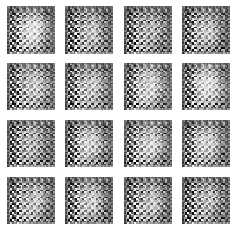

Generator loss     = 0.79663724 
Discriminator loss = 1.2457606
epoch :  1  /  100


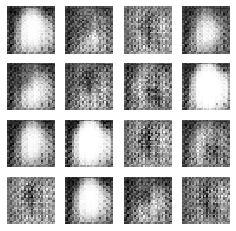

Generator loss     = 0.8020463 
Discriminator loss = 1.3468945
epoch :  2  /  100


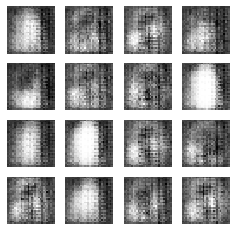

Generator loss     = 0.66701764 
Discriminator loss = 1.3783933
epoch :  3  /  100


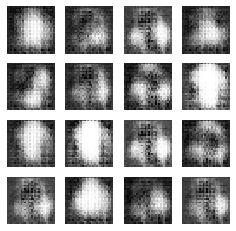

Generator loss     = 0.7119302 
Discriminator loss = 1.342845
epoch :  4  /  100


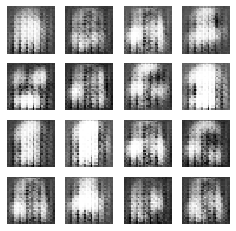

Generator loss     = 0.7293524 
Discriminator loss = 1.3205756
epoch :  5  /  100


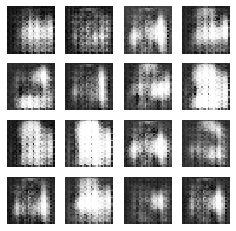

Generator loss     = 0.7615335 
Discriminator loss = 1.2942061
epoch :  6  /  100


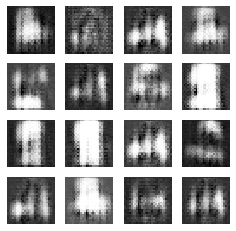

Generator loss     = 0.7705323 
Discriminator loss = 1.2977889
epoch :  7  /  100


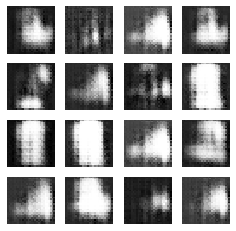

Generator loss     = 0.7675874 
Discriminator loss = 1.2966287
epoch :  8  /  100


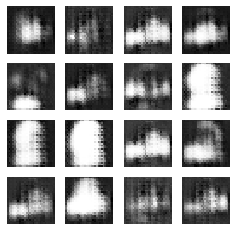

Generator loss     = 0.7879491 
Discriminator loss = 1.2632718
epoch :  9  /  100


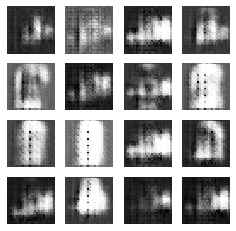

Generator loss     = 0.8280124 
Discriminator loss = 1.2468396
epoch :  10  /  100


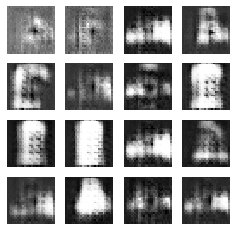

Generator loss     = 0.8614607 
Discriminator loss = 1.2053323
epoch :  11  /  100


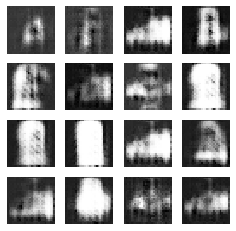

Generator loss     = 0.8657381 
Discriminator loss = 1.1944935
epoch :  12  /  100


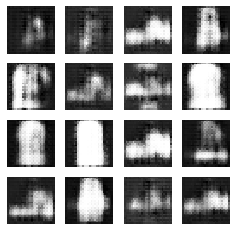

Generator loss     = 0.9058498 
Discriminator loss = 1.1381745
epoch :  13  /  100


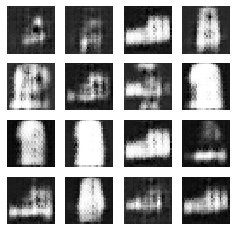

Generator loss     = 0.9254955 
Discriminator loss = 1.1285444
epoch :  14  /  100


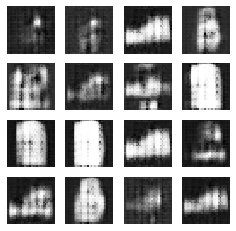

Generator loss     = 0.9346438 
Discriminator loss = 1.099962
epoch :  15  /  100


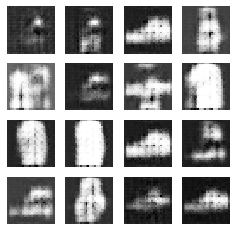

Generator loss     = 0.9928714 
Discriminator loss = 1.0463904
epoch :  16  /  100


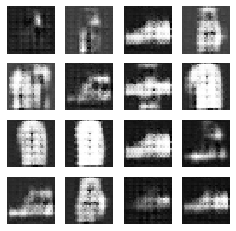

Generator loss     = 0.9852871 
Discriminator loss = 1.0445826
epoch :  17  /  100


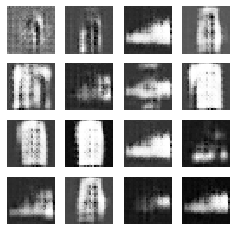

Generator loss     = 1.0050216 
Discriminator loss = 1.023924
epoch :  18  /  100


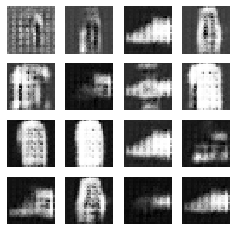

Generator loss     = 1.0108694 
Discriminator loss = 1.0445895
epoch :  19  /  100


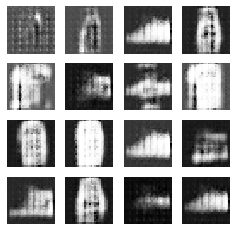

Generator loss     = 1.0246418 
Discriminator loss = 1.019814
epoch :  20  /  100


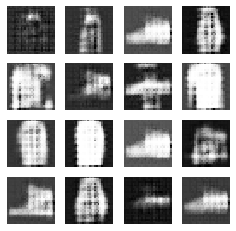

Generator loss     = 1.0472275 
Discriminator loss = 1.0011256
epoch :  21  /  100


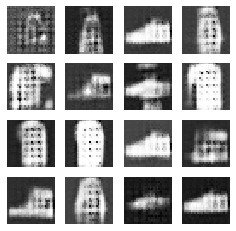

Generator loss     = 1.0366888 
Discriminator loss = 1.0070992
epoch :  22  /  100


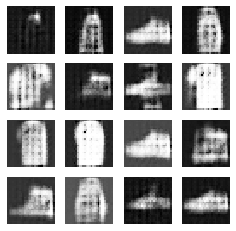

Generator loss     = 1.0356236 
Discriminator loss = 1.0053967
epoch :  23  /  100


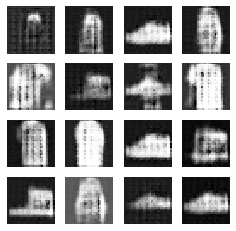

Generator loss     = 1.0324496 
Discriminator loss = 1.0047193
epoch :  24  /  100


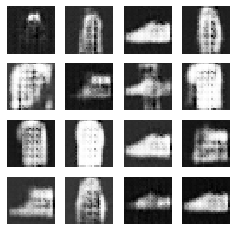

Generator loss     = 1.0389479 
Discriminator loss = 1.0019306
epoch :  25  /  100


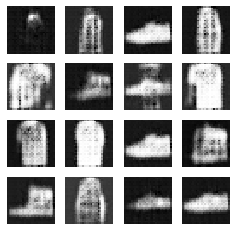

Generator loss     = 1.048405 
Discriminator loss = 0.98722017
epoch :  26  /  100


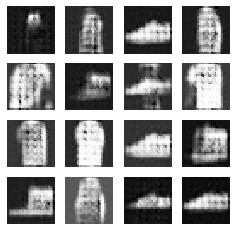

Generator loss     = 1.0537269 
Discriminator loss = 0.97345924
epoch :  27  /  100


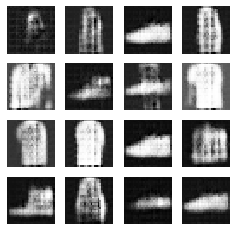

Generator loss     = 1.0519128 
Discriminator loss = 0.97036564
epoch :  28  /  100


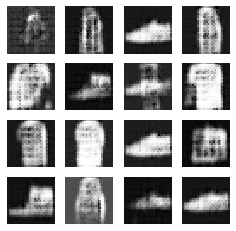

Generator loss     = 1.0759913 
Discriminator loss = 0.9695571
epoch :  29  /  100


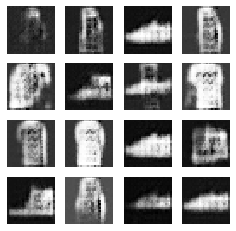

Generator loss     = 1.0896623 
Discriminator loss = 0.95339227
epoch :  30  /  100


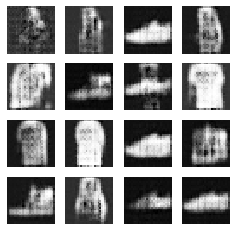

Generator loss     = 1.0871332 
Discriminator loss = 0.952348
epoch :  31  /  100


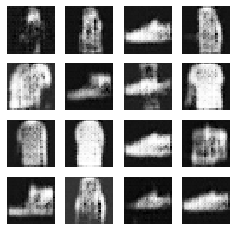

Generator loss     = 1.0901097 
Discriminator loss = 0.96095014
epoch :  32  /  100


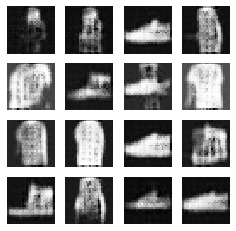

Generator loss     = 1.0955683 
Discriminator loss = 0.94620365
epoch :  33  /  100


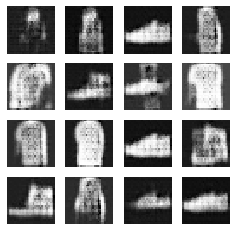

Generator loss     = 1.080915 
Discriminator loss = 0.9503655
epoch :  34  /  100


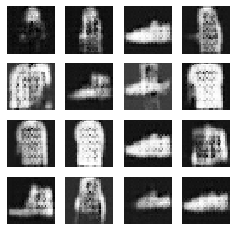

Generator loss     = 1.0916489 
Discriminator loss = 0.9467475
epoch :  35  /  100


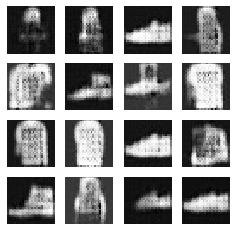

Generator loss     = 1.1044749 
Discriminator loss = 0.95230937
epoch :  36  /  100


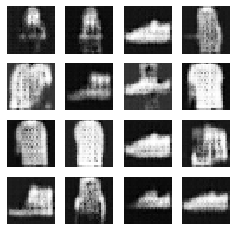

Generator loss     = 1.1266018 
Discriminator loss = 0.93526655
epoch :  37  /  100


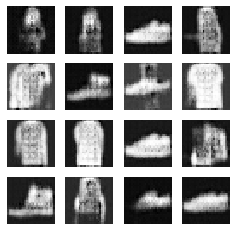

Generator loss     = 1.096138 
Discriminator loss = 0.94747704
epoch :  38  /  100


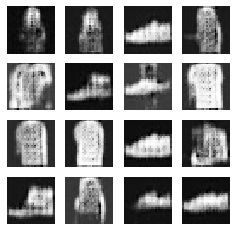

Generator loss     = 1.0841144 
Discriminator loss = 0.96327174
epoch :  39  /  100


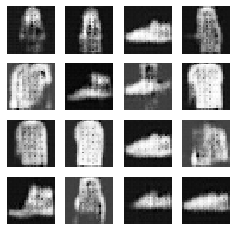

Generator loss     = 1.0963765 
Discriminator loss = 0.9509493
epoch :  40  /  100


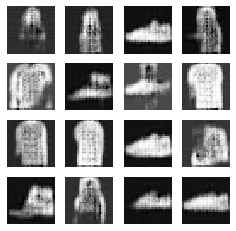

Generator loss     = 1.0925968 
Discriminator loss = 0.95831513
epoch :  41  /  100


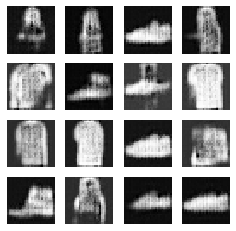

Generator loss     = 1.0836776 
Discriminator loss = 0.96119046
epoch :  42  /  100


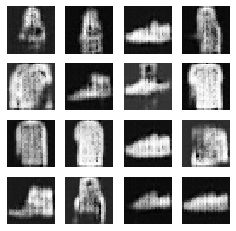

Generator loss     = 1.0831702 
Discriminator loss = 0.96756375
epoch :  43  /  100


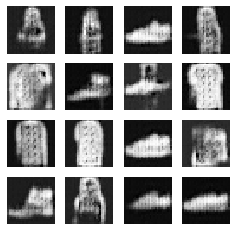

Generator loss     = 1.0872442 
Discriminator loss = 0.95755595
epoch :  44  /  100


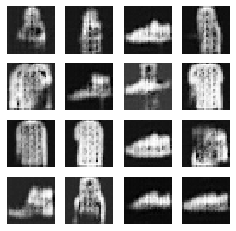

Generator loss     = 1.0825441 
Discriminator loss = 0.9652177
epoch :  45  /  100


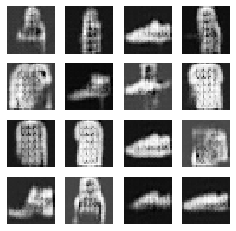

Generator loss     = 1.0824277 
Discriminator loss = 0.95971894
epoch :  46  /  100


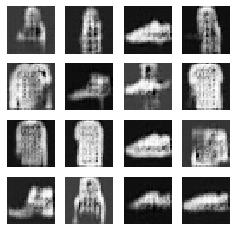

Generator loss     = 1.0926124 
Discriminator loss = 0.95726496
epoch :  47  /  100


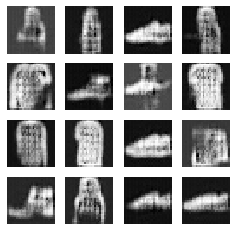

Generator loss     = 1.0897231 
Discriminator loss = 0.9609982
epoch :  48  /  100


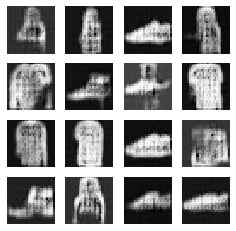

Generator loss     = 1.085431 
Discriminator loss = 0.9667435
epoch :  49  /  100


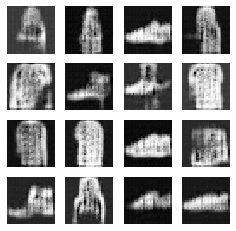

Generator loss     = 1.1029874 
Discriminator loss = 0.9502443
epoch :  50  /  100


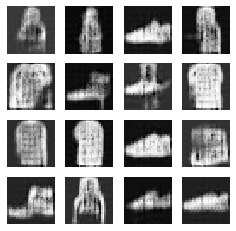

Generator loss     = 1.1287969 
Discriminator loss = 0.9306271
epoch :  51  /  100


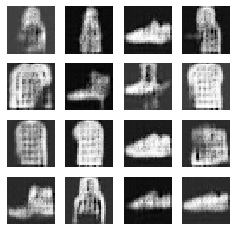

Generator loss     = 1.1145543 
Discriminator loss = 0.93878573
epoch :  52  /  100


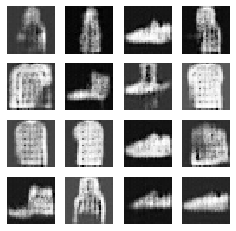

Generator loss     = 1.1115494 
Discriminator loss = 0.9495251
epoch :  53  /  100


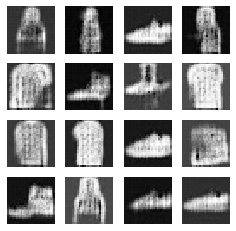

Generator loss     = 1.1181026 
Discriminator loss = 0.94413245
epoch :  54  /  100


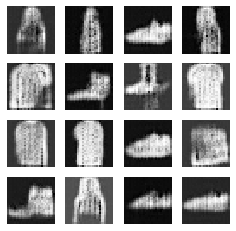

Generator loss     = 1.1227269 
Discriminator loss = 0.9340455
epoch :  55  /  100


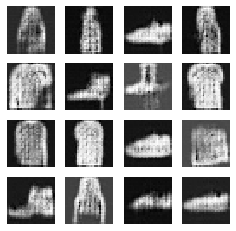

Generator loss     = 1.1400936 
Discriminator loss = 0.914477
epoch :  56  /  100


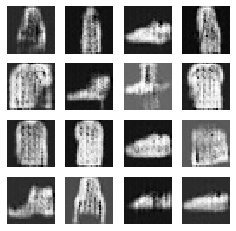

Generator loss     = 1.1466758 
Discriminator loss = 0.9062631
epoch :  57  /  100


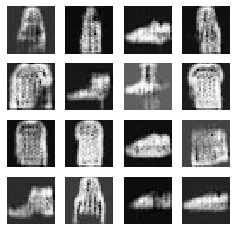

Generator loss     = 1.1362886 
Discriminator loss = 0.9271182
epoch :  58  /  100


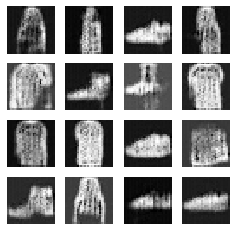

Generator loss     = 1.1364512 
Discriminator loss = 0.91960984
epoch :  59  /  100


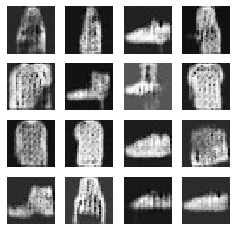

Generator loss     = 1.1554569 
Discriminator loss = 0.8993542
epoch :  60  /  100


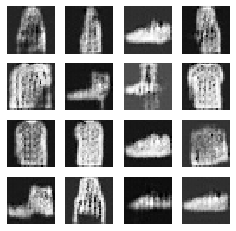

Generator loss     = 1.143446 
Discriminator loss = 0.91576
epoch :  61  /  100


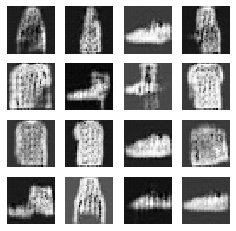

Generator loss     = 1.14188 
Discriminator loss = 0.9169078
epoch :  62  /  100


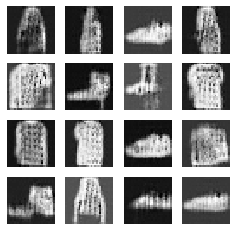

Generator loss     = 1.1629763 
Discriminator loss = 0.89994025
epoch :  63  /  100


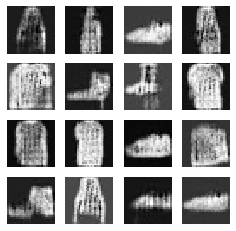

Generator loss     = 1.168153 
Discriminator loss = 0.8878238
epoch :  64  /  100


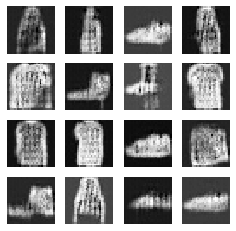

Generator loss     = 1.1403251 
Discriminator loss = 0.9139219
epoch :  65  /  100


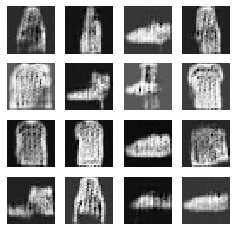

Generator loss     = 1.150125 
Discriminator loss = 0.90524817
epoch :  66  /  100


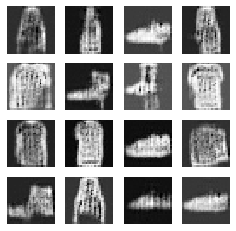

Generator loss     = 1.1716946 
Discriminator loss = 0.8854341
epoch :  67  /  100


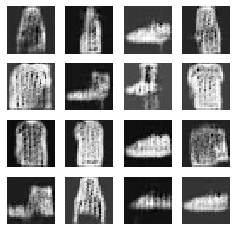

Generator loss     = 1.1718606 
Discriminator loss = 0.8835322
epoch :  68  /  100


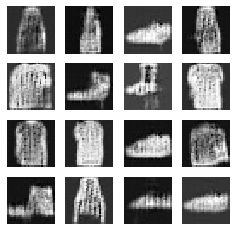

Generator loss     = 1.1509218 
Discriminator loss = 0.90215296
epoch :  69  /  100


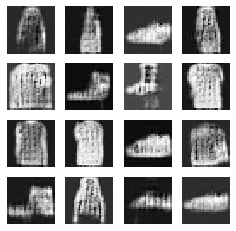

Generator loss     = 1.1757938 
Discriminator loss = 0.8769071
epoch :  70  /  100


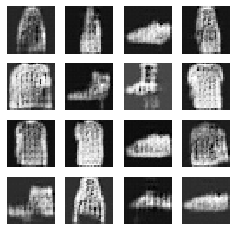

Generator loss     = 1.1750119 
Discriminator loss = 0.8872455
epoch :  71  /  100


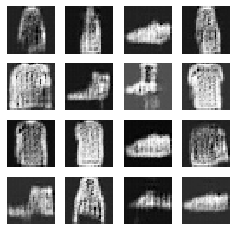

Generator loss     = 1.1692334 
Discriminator loss = 0.8868242
epoch :  72  /  100


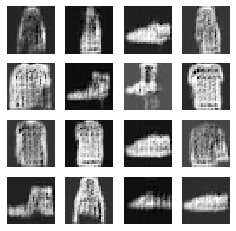

Generator loss     = 1.1881058 
Discriminator loss = 0.8706953
epoch :  73  /  100


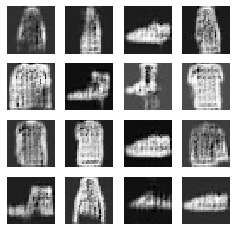

Generator loss     = 1.1897887 
Discriminator loss = 0.8651856
epoch :  74  /  100


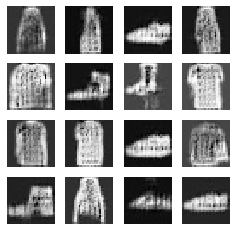

Generator loss     = 1.1868953 
Discriminator loss = 0.87277347
epoch :  75  /  100


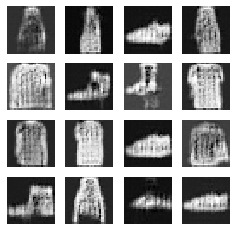

Generator loss     = 1.1855243 
Discriminator loss = 0.8724844
epoch :  76  /  100


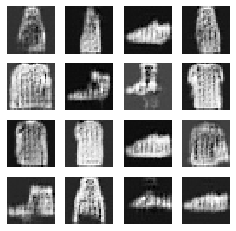

Generator loss     = 1.1925347 
Discriminator loss = 0.8679493
epoch :  77  /  100


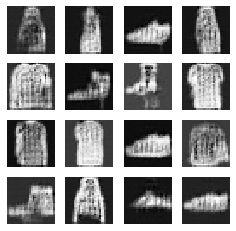

Generator loss     = 1.1999567 
Discriminator loss = 0.8547428
epoch :  78  /  100


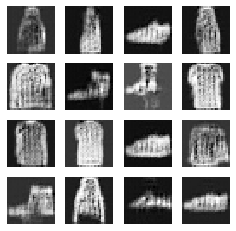

Generator loss     = 1.1883467 
Discriminator loss = 0.8606165
epoch :  79  /  100


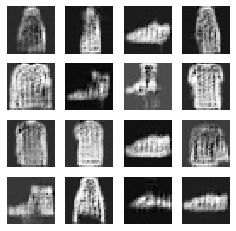

Generator loss     = 1.1916878 
Discriminator loss = 0.86709654
epoch :  80  /  100


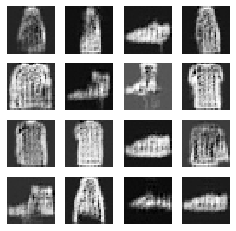

Generator loss     = 1.207007 
Discriminator loss = 0.84312105
epoch :  81  /  100


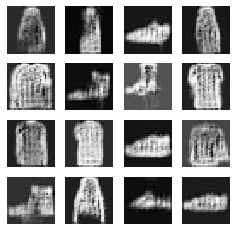

Generator loss     = 1.204128 
Discriminator loss = 0.8498596
epoch :  82  /  100


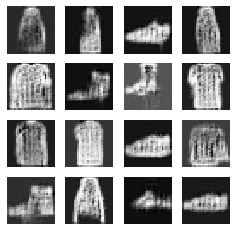

Generator loss     = 1.2035179 
Discriminator loss = 0.8438947
epoch :  83  /  100


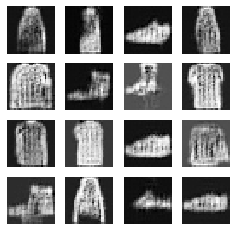

Generator loss     = 1.214355 
Discriminator loss = 0.83473885
epoch :  84  /  100


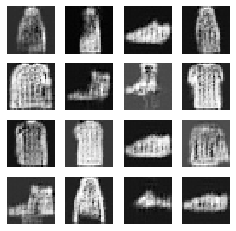

Generator loss     = 1.2305804 
Discriminator loss = 0.82596123
epoch :  85  /  100


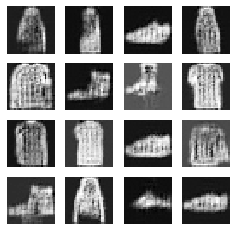

Generator loss     = 1.218718 
Discriminator loss = 0.82915086
epoch :  86  /  100


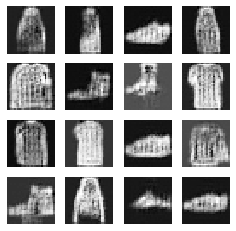

Generator loss     = 1.2249259 
Discriminator loss = 0.82329166
epoch :  87  /  100


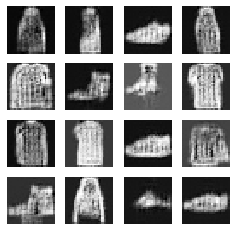

Generator loss     = 1.2445805 
Discriminator loss = 0.8060677
epoch :  88  /  100


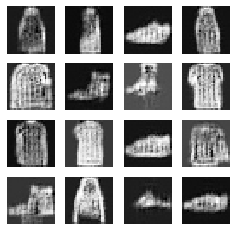

Generator loss     = 1.2430702 
Discriminator loss = 0.8082487
epoch :  89  /  100


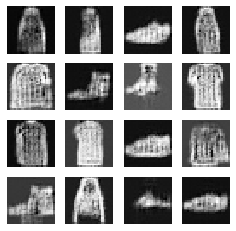

Generator loss     = 1.2370442 
Discriminator loss = 0.8097704
epoch :  90  /  100


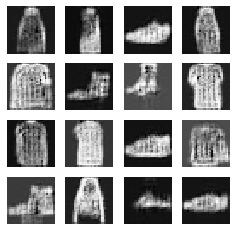

Generator loss     = 1.2458266 
Discriminator loss = 0.8035306
epoch :  91  /  100


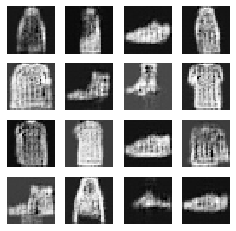

Generator loss     = 1.2708325 
Discriminator loss = 0.7911666
epoch :  92  /  100


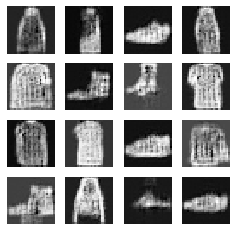

Generator loss     = 1.2624654 
Discriminator loss = 0.79696274
epoch :  93  /  100


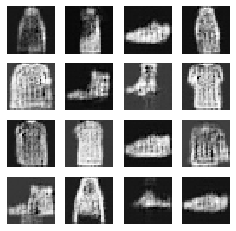

Generator loss     = 1.2796968 
Discriminator loss = 0.78126115
epoch :  94  /  100


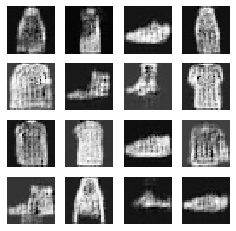

Generator loss     = 1.2764617 
Discriminator loss = 0.7812485
epoch :  95  /  100


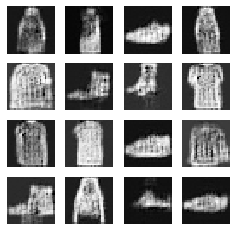

Generator loss     = 1.2686077 
Discriminator loss = 0.78692174
epoch :  96  /  100


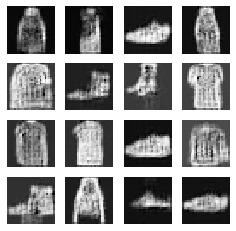

Generator loss     = 1.2888137 
Discriminator loss = 0.7753887
epoch :  97  /  100


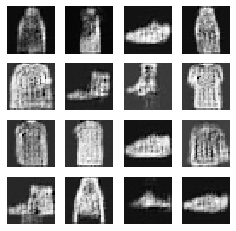

Generator loss     = 1.2852241 
Discriminator loss = 0.77672917
epoch :  98  /  100


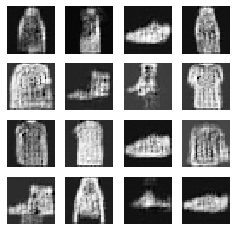

Generator loss     = 1.280628 
Discriminator loss = 0.7822123
epoch :  99  /  100


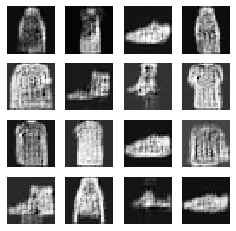

Generator loss     = 1.2924272 
Discriminator loss = 0.77245593


In [21]:
import matplotlib.pyplot as plt

discriminator = make_discriminator_model()
discriminator.summary()
discriminator_optimizer = make_discriminator_optimizer()

generator = make_generator_model()
generator.summary()
generator_optimizer =  make_generator_optimizer()

#################################################    
num_examples_to_generate=16
def generate_and_save_images(model, epoch, test_input=tf.random.normal([num_examples_to_generate, noise_dim])):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset):
  for ep in range(epoch):
    print("epoch : ",ep, " / ", epoch)
    gen_losses, disc_losses = [], []
    for it in range(int(dataset.shape[0] / batch_size)):
      image_batch = dataset[np.random.randint(low=0,high=dataset.shape[0],size=batch_size)]
      gen_loss, disc_loss = train_step(image_batch)
      gen_losses.append(gen_loss.numpy())
      disc_losses.append(disc_loss.numpy())

    generate_and_save_images(generator, ep)

    print("Generator loss     =",mean(gen_losses), "\nDiscriminator loss =",mean(disc_losses))

#################################################    
train(train_images)

## DCAA

#################################################
# DISCRIMINATOR
#################################################
Model: "model_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_158 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_303 (Conv2D)          (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_561 (LeakyReLU)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_562 (LeakyReLU)  (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_103 (Flatten)        (None, 3136)              0         
_______

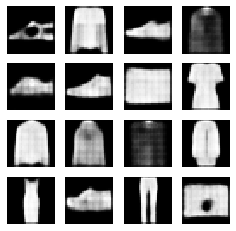

epoch :  0  /  100
0 /  234
50 /  234
100 /  234
150 /  234
200 /  234


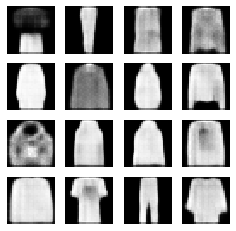

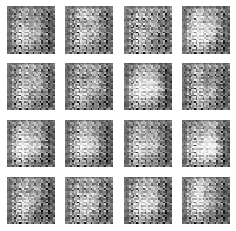

Generator loss     = 0.78435177 
Discriminator loss = 1.3268554 
A-Autoencoder loss = 0.6968878 
Autoencoder   loss = 0.2829764840694574
epoch :  1  /  100
0 /  234


In [0]:
import matplotlib.pyplot as plt

discriminator = make_discriminator_model()
print("#################################################\n# DISCRIMINATOR\n#################################################")
discriminator.summary()
discriminator_optimizer = make_discriminator_optimizer()

generator = make_generator_model()
print("#################################################\n#GENERATOR\n#################################################")
generator.summary()
generator_optimizer =  make_generator_optimizer()

autoencoder, _, _ = make_conv_autoencoder_model()
autoencoder.compile(optimizer=optimizer, loss=loss)
print("#################################################\n# AUTOENCODER\n#################################################")
autoencoder.summary()
autoencoder_optimizer =  make_autoencoder_optimizer()

#################################################    
num_examples_to_generate=16
def generate_and_save_images(model, epoch, test_input=tf.random.normal([num_examples_to_generate, noise_dim]), norm=0):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as ae_tape:
      images = autoencoder(images, training=True)      

      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      ae_loss = autoencoder_loss(real_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_autoencoder = ae_tape.gradient(ae_loss, autoencoder.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))

    return gen_loss, disc_loss, ae_loss

def train(dataset):

  # Autoencoder pre-training
  autoencoder.fit(dataset, dataset,
                epochs=5,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_images, test_images))
  
  generate_and_save_images(autoencoder, -1, norm=1,
                           test_input=dataset[np.random.randint(low=0,high=dataset.shape[0],size=num_examples_to_generate)])

  # Training pipeline
  for ep in range(epoch):
    print("epoch : ",ep, " / ", epoch)
    gen_losses, disc_losses, ae_losses, aae_losses = [], [], [], []
    for it in range(int(dataset.shape[0] / batch_size)):
      if it % 50 == 0:
        print(it,"/ ",int(dataset.shape[0] / batch_size))
      image_batch = dataset[np.random.randint(low=0,high=dataset.shape[0],size=batch_size)]

      history = autoencoder.fit(image_batch, image_batch,
                epochs=1, verbose=0,
                batch_size=batch_size,
                shuffle=True)#,
                #validation_data=(test_images, test_images))
      ae_losses.append(history.history['loss'][0])
      
      gen_loss, disc_loss, ae_loss = train_step(image_batch)
      gen_losses.append(gen_loss.numpy())
      disc_losses.append(disc_loss.numpy())
      aae_losses.append(ae_loss.numpy())

    generate_and_save_images(autoencoder, -1*epoch, norm=1,
                           test_input=dataset[np.random.randint(low=0,high=dataset.shape[0],size=num_examples_to_generate)])
    generate_and_save_images(generator, ep)

    print(  "Generator loss     =",mean(gen_losses), 
          "\nDiscriminator loss =",mean(disc_losses), 
          "\nA-Autoencoder loss =",mean(aae_losses),
          "\nAutoencoder   loss =",mean(ae_losses))

#################################################    
train(train_images)